## Conformal Prediction for Regression
This notebook demonstrates usage of conformal prediction for regression models using single and multiple region models. The region uncertainity estimator treats the provided base (user) model as black box model.


<a id='notebook_workflow'></a>
## Notebook Workflow
- [Imports](#imports)
- [Load Dataset](#load_dataset)
- [Plot Data](#plot_data)
- [Train Regressor](#train_classifier)
- [Initialize Conformal Prediction Using Single Region](#initialize_cp_single_region)
- [Emit A Conformal Prediction_Model](#emit_cp_sr_model)
- [Score The Conformal Prediction_Model](#score_cp_sr_model)
- [Initialize Conformal Prediction Using Multi Region](#initialize_cp_multi_region)
- [Emit A Conformal Prediction_Model](#emit_cp_mr_model)
- [Score The Conformal Prediction_Model](#score_cp_mr_model)
- [Single Region Vs Multi Region](#region_class_comparison)


<a id='imports'></a>
### Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
from joblib import dump
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from model_trust.evaluation.metrics import get_group_metrics
from model_trust.datasets.synthetic_data import load_linear_2_region_data
from model_trust.regression.region_uncertainty_estimation import RegionUncertaintyEstimator
from model_trust.regression.standalone_inference import cp_inference

warnings.filterwarnings("ignore")

### Load Dataset

In [2]:
quantile = 0.9
dataset = load_linear_2_region_data(nsamples=3000,
                                      quantile=quantile,
                                      sigma_0=1,
                                      sigma_1=4,
                                      test_ratio=0.2,
                                      cal_ratio=0.2,
                                      seed=42,)

data = dataset["data"]
features = dataset["features"]
target = dataset["target"]
X = data[features].values
Y = data[target].values

x_train = dataset["x_train"]
x_test = dataset["x_test"]
x_cal = dataset["x_cal"]

y_train = dataset["y_train"]
y_test = dataset["y_test"]
y_cal = dataset["y_cal"]


### Plot Data

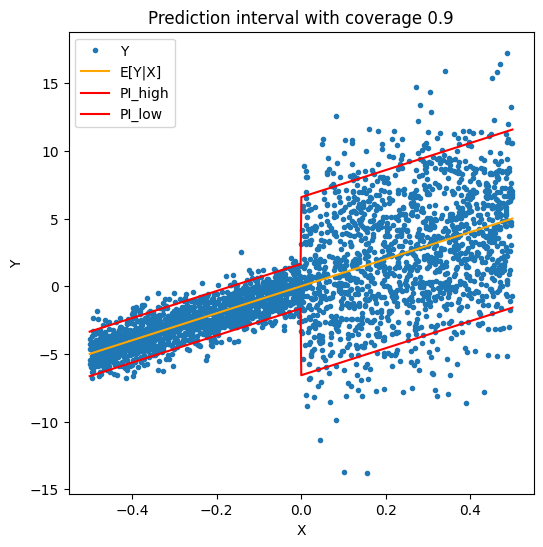

In [3]:
pi_gt_low = data["PI_GT_LOW"].values
pi_gt_high = data["PI_GT_HIGH"].values
Y_mean = data["Y_mean"].values
coverage_empirical = np.mean((Y <= pi_gt_high)& (Y >= pi_gt_low))

X_sort = np.sort(X.flatten())
X_sort_indices = np.argsort(X.flatten())

plt.figure(figsize=(6,6))
plt.plot(X, Y, ".", label="Y")
# plt.title("COVERAGE TARGET {}; EMPIRICAL : {}".format(str(quantile), str(np.round(coverage_empirical,2)))) # title ??
plt.title("Prediction interval with coverage {}".format(str(quantile)))

plt.plot(X_sort, Y_mean[X_sort_indices],  'orange', label = 'E[Y|X]')
plt.plot(X_sort, pi_gt_high[X_sort_indices], 'r', label = 'PI_high')
plt.plot(X_sort, pi_gt_low[X_sort_indices], 'r', label = 'PI_low')
plt.xlabel("X")
plt.ylabel("Y")

plt.legend()
plt.show()

### Train Regressor

In [4]:
base_model = LinearRegression().fit(x_train, y_train)
print('Train/Test R2 scores')
y_pred_cal = base_model.predict(x_cal)
y_pred = base_model.predict(x_test)
print(base_model.score(x_train, y_train), base_model.score(x_test, y_test))

Train/Test R2 scores
0.4662926288878644 0.48260603840297045


### Initialize Conformal Prediction using Single Region

In [5]:
cp_config_input = {}
cp_config_input['confidence'] = quantile*100
cp_config_input['regions_model'] = "single_region"

# single region does not have region parameters

cp_single_region_model = RegionUncertaintyEstimator(**cp_config_input)

### Emit a Conformal Prediction Model

In [6]:
cp_single_region_model.fit(x_cal, y_cal, y_pred_cal)

In [7]:
dump(cp_single_region_model, 'cp_single_region_model.joblib')

['cp_single_region_model.joblib']

In [8]:
cp_single_region_model_learned_params = cp_single_region_model.export_learned_config()

In [9]:
dump(cp_single_region_model_learned_params, 'cp_single_region_model_learned_params.joblib')

['cp_single_region_model_learned_params.joblib']

### Score the Conformal Prediction Model

Prediction intervals for single instance.

In [10]:
cp_single_region_model.predict(x_test[0:1], y_pred[0:1])

array([[-2.44483532,  7.28648244]])

In [11]:
dump((x_test[0:1], y_pred[0:1]), 'input_tuple.joblib')

['input_tuple.joblib']

In [12]:
# testing using inference function
cp_inference(learned_config=cp_single_region_model_learned_params, X=x_test[0:1], y_pred=y_pred[0:1], percentile=90)

array([[-2.44483532,  7.28648244]])

Prediction intervals for multiple instance.

In [13]:
x_test_sort_indices = np.argsort(x_test.flatten())
y_pred_single_region = cp_single_region_model.predict(x_test[x_test_sort_indices],y_pred[x_test_sort_indices])
y_pred_single_region.shape

(600, 2)

### Initialize Conformal Prediction using Multi Region

In [14]:
cp_init_params = {}
cp_init_params['confidence'] = quantile*100
cp_init_params['regions_model'] = "multi_region"

# region parameters
cp_init_params["multi_region_model_selection_metric"] = "coverage_ratio"
cp_init_params["multi_region_model_selection_stat"] = "min"
cp_init_params["multi_region_min_group_size"] = 20

cp_multi_region_model = RegionUncertaintyEstimator(**cp_init_params)

### Emit a Conformal Prediction Model

In [15]:
cp_multi_region_model.fit(x_cal, y_cal, y_pred_cal)

Best Params :{'min_samples_leaf': 100, 'ccp_alpha': 0.1, 'max_depth': 1, 'random_state': 42}
Best model :DecisionTreeRegressor(ccp_alpha=0.1, max_depth=1, min_samples_leaf=100,
                      random_state=42)


In [16]:
dump(cp_multi_region_model, 'cp_multi_region_model.joblib')

['cp_multi_region_model.joblib']

In [17]:
cp_multi_region_model_learned_params = cp_multi_region_model.export_learned_config()

In [18]:
dump(cp_multi_region_model_learned_params, 'cp_multi_region_model_learned_params.joblib')

['cp_multi_region_model_learned_params.joblib']

### Score the Conformal Prediction Model

Prediction intervals for single instance.

In [19]:
cp_multi_region_model.predict(x_test[0:1], y_pred[0:1])

array([[-4.58082584,  9.42247297]])

In [20]:
# testing using inference function
cp_inference(learned_config=cp_multi_region_model_learned_params, X=x_test[0:1], y_pred=y_pred[0:1])

array([[-4.58082584,  9.42247297]])

Prediction intervals for multiple instance.

In [21]:
y_pred_multi_region = cp_multi_region_model.predict(x_test[x_test_sort_indices], y_pred[x_test_sort_indices])
y_pred_multi_region

array([[-6.71866571, -3.24156102],
       [-6.66176933, -3.18466464],
       [-6.64186962, -3.16476493],
       ...,
       [-1.96906037, 12.03423844],
       [-1.96666746, 12.03663135],
       [-1.9571266 , 12.04617221]])

In [22]:
# testing using inference function
y_pred_multi_region_2 = cp_inference(learned_config=cp_multi_region_model_learned_params, X=x_test[x_test_sort_indices], y_pred=y_pred[x_test_sort_indices])
y_pred_multi_region_2

array([[-6.71866571, -3.24156102],
       [-6.66176933, -3.18466464],
       [-6.64186962, -3.16476493],
       ...,
       [-1.96906037, 12.03423844],
       [-1.96666746, 12.03663135],
       [-1.9571266 , 12.04617221]])

In [23]:
cp_multi_region_model.regions_model

### Single Region Vs Multi Region

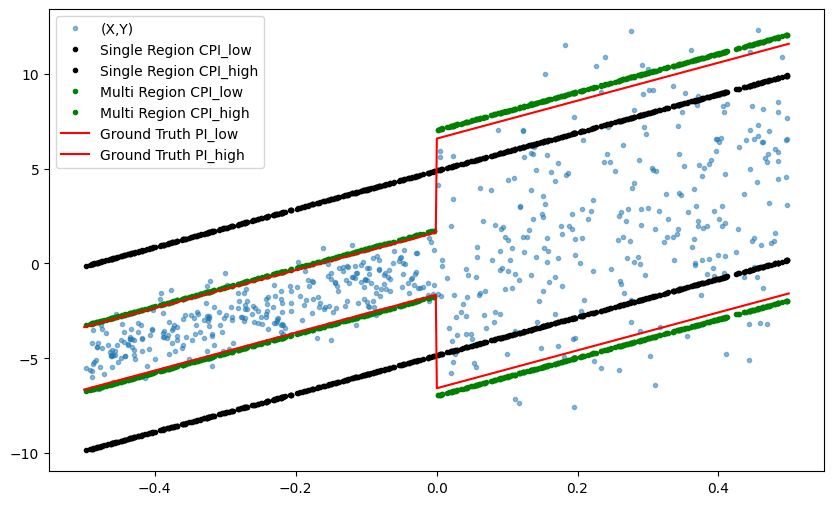

In [24]:
X_sort = np.sort(X.flatten())
X_sort_indices = np.argsort(X.flatten())

x_test_sort = np.sort(x_test.flatten())
x_test_sort_indices = np.argsort(x_test.flatten())

pi_gt_low = data["PI_GT_LOW"].values
pi_gt_high = data["PI_GT_HIGH"].values

plt.rcParams["figure.figsize"] = (10, 6)

plt.plot(x_test_sort, y_test[x_test_sort_indices], '.', alpha = 0.5, label='(X,Y)')
plt.plot(x_test_sort, y_pred_single_region[:, 0], 'k.', label = 'Single Region CPI_low')
plt.plot(x_test_sort, y_pred_single_region[:, 1], 'k.', label = 'Single Region CPI_high')

plt.plot(x_test_sort, y_pred_multi_region[:, 0], 'g.', label = 'Multi Region CPI_low')
plt.plot(x_test_sort, y_pred_multi_region[:, 1], 'g.', label = 'Multi Region CPI_high')

plt.plot(X_sort, pi_gt_low[X_sort_indices], 'r', label = 'Ground Truth PI_low')
plt.plot(X_sort, pi_gt_high[X_sort_indices], 'r', label = 'Ground Truth PI_high')

plt.legend(loc='upper left', bbox_to_anchor=(0, 1.0))
plt.show()